In [163]:
using Plots
using MMCAcovid19
using Random
using Distributions
using LightGraphs
using NamedArrays
using LinearAlgebra


# Number of strata
G = 3

# Number of patches
M = 5

g_probs = [0.1, 0.6, 0.3]
m_probs = [0.05, 0.10, 0.15, 0.30, 0.40]
probs = transpose(m_probs) .* g_probs
total_population = 1000000
distrib = Multinomial(total_population, reshape(probs, (1, G * M))[1, :])
nᵢᵍ = convert.(Float64, reshape(rand(distrib), (G, M)))

# Strata contacts
C = [0.5980 0.3849 0.0171
     0.2440 0.7210 0.0350
     0.1919 0.5705 0.2376]

# network
network = erdos_renyi(M, 0.7, is_directed=true)
for i in 1:M
  add_edge!(network, i, i)   # add self-loops
end
# list of edges
L = ne(network)
edgelist = zeros(Int64, L, 2)
edgelist[:, 1] .= src.(edges(network))
edgelist[:, 2] .= dst.(edges(network))
# list of commuting probabilities
Rᵢⱼ = rand(L)
sum_r = zeros(M)
for e in 1:L   # find output strengths
  i = edgelist[e, 1]
  sum_r[i] += Rᵢⱼ[e]
end
for e in 1:L   # normalize weights
  i = edgelist[e, 1]
  Rᵢⱼ[e] /= sum_r[i]
end

# Average number of contacts per strata
kᵍ = [11.8, 13.3, 6.6]

# Average number of contacts at home per strata
kᵍ_h = [3.15, 3.17, 3.28]

# Average number of contacts at work per strata
kᵍ_w = [1.72, 5.18, 0.0]

# Degree of mobility per strata
pᵍ = [0.0, 1.0, 0.05]

# Patch surfaces (in km²)
sᵢ = [10.6, 23.0, 26.6, 5.7, 61.6]

# Density factor
ξ = 0.01

# Average household size
σ = 2.5

# Infectivity of infected
βᴵ = 0.075

# Infectivity of asymptomatic
βᴬ = 0.5 * βᴵ

# Exposed rate
ηᵍ = [1/2.444, 1/2.444, 1/2.444]

# Asymptomatic infectious rate
αᵍ = [1/5.671, 1/2.756, 1/2.756]

# Infectious rate
μᵍ = [1/1.0, 1/3.915, 1/3.915]

# Direct death probability
θᵍ = [0.0, 0.008, 0.047]

# ICU probability
γᵍ = [0.0003, 0.003, 0.026]

# Pre-deceased rate
ζᵍ = [1/7.084, 1/7.084, 1/7.084]

# Pre-hospitalized in ICU rate
λᵍ = [1/4.084, 1/4.084, 1/4.084]

# Fatality probability in ICU
ωᵍ = [0.3, 0.3, 0.3]

# Death rate in iCU
ψᵍ = [1/7.0, 1/7.0, 1/7.0]

# ICU discharge rate
χᵍ = [1/20.0, 1/20.0, 1/20.0]

# Number of timesteps
T = 10

# Initial number of exposed individuals
E₀ = zeros(G, M)

# Initial number of infectious asymptomatic individuals
A₀ = zeros(G, M)
A₀[2, 5] = 2.0
A₀[3, 3] = 1.0

# Initial number of infectious symptomatic individuals
I₀ = zeros(G, M)
I₀[2, 5] = 1.0

# Timestep of application of containment
tᶜ = 30

# Mobility reduction
κ₀ = 0.65

# Permeability of confined households
ϕ = 0.174

# Social distancing
δ = 0.207

# List of timesteps of application of containments
tᶜs = [30, 60, 90, 120]

# List of mobility reductions
κ₀s = [0.65, 0.75, 0.65, 0.55]

# List of permeabilities of confined households
ϕs = [0.174, 0.174, 0.174, 0.174]

# List of social distancings
δs = [0.207, 0.207, 0.207, 0.207]

4-element Array{Float64,1}:
 0.207
 0.207
 0.207
 0.207

In [95]:
using NamedArrays
using DataFrames
using Distributions

function sample_initial_parameters(num_params)
    DataFrame(
        id=1:num_params,
        beta=rand(Uniform(0, 0.1), num_params),
        scale_beta=rand(Uniform(0.4, 0.6), num_params)
    )
end

function resample_parameters(accepted, num_params)
    params_names = ["beta", "scale_beta"]
    Σ = cov(Array(accepted[:, params_names]))
    μ = mean(Array(accepted[:, params_names]), dims=1)[1,:]
    values = rand(MvNormal(μ, Σ), num_params)
    df = DataFrame(transpose(values), params_names)
    df[:, "id"] = 1:num_params
    return df
end

function resample_compartments(compartments, sample_size=10000)
    # Resample compartments at a given time
    # Input compartments should have shape: (G, M, num_compartments, num_params)
    # Output have the same shape as input
    G, M, num_compartments, num_params = size(compartments)
    X = transpose(reshape(compartments[:,:,:,:], (G*M*num_compartments, num_params)))
    μ = mean(X, dims=1)[1,:]
    Σ = cov(X)
    Σ = Σ + 1e-15*I # avoid problem: "Cholesky factorization failed", as some variables appear to be linear combinations of others, I think it might be (i did not checked) several age groups of the same patch. More info here: https://stackoverflow.com/questions/57559589/distributions-jl-do-not-accept-my-non-positive-definite-covariance-function-w
    new_compartments = rand(MvNormal(μ, Σ), sample_size)
    return reshape(new_compartments, (G, M, num_compartments, sample_size))
end


function calculate_incidence(epi_params, population)
    prevalence = sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                      population.nᵢᵍ, dims = (1))[1,:,:]
    incidence = diff(prevalence, dims=2)
    return incidence, prevalence
end

function compartments_as_matrix(epi_params, population)
    num_compartments = 10
    compartments_names = ["S", "E", "A", "I", "PH", "PD", "HR", "HD", "D", "R"]
    compartments = NamedArray(
        zeros(population.G, population.M, epi_params.T, num_compartments),
        (1:population.G, 1:population.M, 1:epi_params.T, compartments_names),
        ("G", "M", "t", "compartment")
    )
    compartments[:, :, :, 1] = epi_params.ρˢᵍ .* population.nᵢᵍ
    compartments[:, :, :, 2] = epi_params.ρᴱᵍ .* population.nᵢᵍ
    compartments[:, :, :, 3] = epi_params.ρᴬᵍ .* population.nᵢᵍ
    compartments[:, :, :, 4] = epi_params.ρᴵᵍ .* population.nᵢᵍ
    compartments[:, :, :, 5] = epi_params.ρᴾᴴᵍ .* population.nᵢᵍ
    compartments[:, :, :, 6] = epi_params.ρᴾᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 7] = epi_params.ρᴴᴿᵍ .* population.nᵢᵍ
    compartments[:, :, :, 8] = epi_params.ρᴴᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 9] = epi_params.ρᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 10] = epi_params.ρᴿᵍ .* population.nᵢᵍ
    return compartments
end

function store_compartments!(compartments, i, epi_params, population)
    compartments[:, :, :, 1, i] = epi_params.ρˢᵍ .* population.nᵢᵍ
    compartments[:, :, :, 2, i] = epi_params.ρᴱᵍ .* population.nᵢᵍ
    compartments[:, :, :, 3, i] = epi_params.ρᴬᵍ .* population.nᵢᵍ
    compartments[:, :, :, 4, i] = epi_params.ρᴵᵍ .* population.nᵢᵍ
    compartments[:, :, :, 5, i] = epi_params.ρᴾᴴᵍ .* population.nᵢᵍ
    compartments[:, :, :, 6, i] = epi_params.ρᴾᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 7, i] = epi_params.ρᴴᴿᵍ .* population.nᵢᵍ
    compartments[:, :, :, 8, i] = epi_params.ρᴴᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 9, i] = epi_params.ρᴰᵍ .* population.nᵢᵍ
    compartments[:, :, :, 10, i] = epi_params.ρᴿᵍ .* population.nᵢᵍ
end

function set_compartments!(epi_params, compartments)
    @assert size(compartments) == (size(epi_params.ρˢᵍ)[1], size(epi_params.ρˢᵍ)[2], 10)
    total_population = sum(compartments, dims=(3))[:,:,1]
    epi_params.ρˢᵍ[:,:,1] .= compartments[:, :, 1] ./ total_population
    epi_params.ρᴱᵍ[:,:,1] .= compartments[:, :, 2] ./ total_population
    epi_params.ρᴬᵍ[:,:,1] .= compartments[:, :, 3] ./ total_population
    epi_params.ρᴵᵍ[:,:,1] .= compartments[:, :, 4] ./ total_population
    epi_params.ρᴾᴴᵍ[:,:,1] .= compartments[:, :, 5] ./ total_population
    epi_params.ρᴾᴰᵍ[:,:,1] .= compartments[:, :, 6] ./ total_population
    epi_params.ρᴴᴿᵍ[:,:,1] .= compartments[:, :, 7] ./ total_population
    epi_params.ρᴴᴰᵍ[:,:,1] .= compartments[:, :, 8] ./ total_population
    epi_params.ρᴰᵍ[:,:,1] .= compartments[:, :, 9] ./ total_population
    epi_params.ρᴿᵍ[:,:,1] .= compartments[:, :, 10] ./ total_population
end


function run_simulation(T; initial_compartments=nothing)
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)
    
    reset_params!(epi_params, population)
    
    if initial_compartments != nothing
        set_compartments!(epi_params, initial_compartments)
    else
        set_initial_infected!(epi_params, population, E₀, A₀, I₀)
    end

    # Run the model
    run_epidemic_spreading_mmca!(epi_params, population; verbose = true)
    
    return epi_params, population
end

function plot_simulation(compartments)
    totals = sum(compartments, dims=(1,2))[1,1,:,:]
    plot([totals[:, "E"], totals[:, "A"], totals[:, "I"], totals[:, "D"]], label=["E" "A" "I" "D"])
end

function RMSE(x, y; sumpatches=true)
    # esta funcion calcula el Root Mean Square Error de cada trajectoria simulada (x)
    # contra la trajectoria real (y), generando un vector de errores, uno por cada parche
    # Las dimensiones deben ser: 
    #  x = ("parche", "tiempo", "simulacion") ó ("parche", "tiempo")
    #  y = ("parche", "tiempo")
    e = x .- y
    se = map(abs2, e)
    mse = mean(se, dims=2)
    rmse = map(sqrt, mse)
    if sumpatches
        return sum(rmse, dims=1)
    else
        return rmse
    end
end


RMSE (generic function with 1 method)

(3, 5, 300, 10)

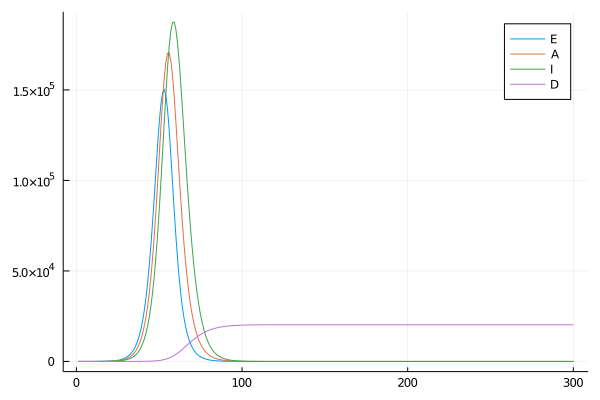

In [16]:
# CONTROL SIMULATION

population1 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params1 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 300)

# Run the model
reset_params!(epi_params1, population1)
set_initial_infected!(epi_params1, population1, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params1, population1; verbose = false)

incidence1, prevalence1 = calculate_incidence(epi_params1, population1)

compartments1 = compartments_as_matrix(epi_params1, population1)
print(size(compartments1))
plot_simulation(compartments1)

In [105]:
num_windows = 20
window_size = 30
T = 100
num_compartments = 10
num_simulations = 10000
num_accept = 1000

1000

In [106]:
# Iteration 1
# Run 10000 simulations, select best 1000, sample from multivariate compartments

function run_simulations(df, realIncidence, T; initial_compartments=nothing)
    num_params = size(df)[1]
    
    # reusable structures
    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, T)

    # Arrays where the output variables will be stored
    prevalence = zeros(Float64, M, T, num_params)
    incidence  = zeros(Float64, M, T - 1, num_params)
    compartments = zeros(Float64, G, M, T, num_compartments, num_params)
    
    for i in 1:num_params
        # Set epidemic params to the ones speficied on the DF
        
        params_names = ["beta", "scale_beta"]
        beta, scale_beta = df[i, params_names]
        epi_params.βᴵ .= beta
        epi_params.βᴬ .= scale_beta * beta
        
        reset_params!(epi_params, population)

        if initial_compartments != nothing
            if length(size(initial_compartments)) == 3
                set_compartments!(epi_params, initial_compartments)
            else
                set_compartments!(epi_params, initial_compartments[:,:,:,i])
            end
        else
            set_initial_infected!(epi_params, population, E₀, A₀, I₀)
        end

        # Run the model
        run_epidemic_spreading_mmca!(epi_params, population; verbose = false)

        # Store compartments
        store_compartments!(compartments, i, epi_params, population)

        # Calculate prevalence and incidence
        prevalence[:,:,i] = sum((epi_params.ρᴵᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴴᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴴᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴾᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴰᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴿᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴬᵍ[:, :, 1:epi_params.T] .+
                                       epi_params.ρᴱᵍ[:, :, 1:epi_params.T]) .*
                                          population.nᵢᵍ, dims = (1))[1,:,:]
        incidence[:,:,i] = diff(prevalence[:,:,i], dims=2)
    end
    score = RMSE(incidence, realIncidence)[1,1,:]
    df[!, "score"] = score
    accepted_params = sort(df, "score")[1:num_accept, :]
    accepted_indexes = accepted_params[:, "id"]
    accepted_compartments = compartments[:,:,:,:,accepted_indexes]
    return accepted_params, accepted_compartments
end

run_simulations (generic function with 2 methods)

In [107]:
# run 10 iterations of ABC to fit the first time window

df = sample_initial_parameters(num_simulations)
initial_comps = compartments1[:,:,1,:]
real_incidence = incidence1[:,1:window_size-1]

for i in 1:10
    accepted_params, accepted_compartments = run_simulations(df, real_incidence, window_size, initial_compartments=initial_comps)
    println(accepted_params[1:10, :])
    df = resample_parameters(accepted_params, num_simulations)
end

10×4 DataFrame
│ Row │ id    │ beta      │ scale_beta │ score    │
│     │ Int64 │ Float64   │ Float64    │ Float64  │
├─────┼───────┼───────────┼────────────┼──────────┤
│ 1   │ 9745  │ 0.077041  │ 0.471242   │ 0.446652 │
│ 2   │ 801   │ 0.0802857 │ 0.428791   │ 0.632903 │
│ 3   │ 9857  │ 0.0704693 │ 0.569387   │ 0.924437 │
│ 4   │ 5565  │ 0.0803793 │ 0.427283   │ 0.973163 │
│ 5   │ 5744  │ 0.0734016 │ 0.52286    │ 1.09526  │
│ 6   │ 1058  │ 0.0774566 │ 0.465089   │ 1.42804  │
│ 7   │ 7321  │ 0.0696957 │ 0.580883   │ 1.51283  │
│ 8   │ 4517  │ 0.0767438 │ 0.474723   │ 1.56649  │
│ 9   │ 7026  │ 0.0736549 │ 0.518836   │ 1.56845  │
│ 10  │ 1508  │ 0.0719367 │ 0.546545   │ 1.57034  │
10×4 DataFrame
│ Row │ beta      │ scale_beta │ id    │ score     │
│     │ Float64   │ Float64    │ Int64 │ Float64   │
├─────┼───────────┼────────────┼───────┼───────────┤
│ 1   │ 0.0746098 │ 0.505622   │ 9363  │ 0.0502738 │
│ 2   │ 0.0752199 │ 0.496898   │ 5572  │ 0.0947383 │
│ 3   │ 0.0754315 │ 0.493932 

In [113]:
size(compartments)

(3, 5, 10, 1000)

In [112]:
t = window_size
compartments = accepted_compartments[:,:,t,:,:]
G, M, num_compartments, num_params = size(compartments)
X = transpose(reshape(compartments[:,:,:,:], (G*M*num_compartments, num_params)))
μ = mean(X, dims=1)[1,:]
Σ = cov(X)

150×150 Array{Float64,2}:
  1.7289e-6   -2.21984e-6  -6.36621e-7  …   6.67095e-6   1.69714e-6
 -2.21984e-6   3.72149e-6   1.02686e-6     -9.74122e-6  -2.44082e-6
 -6.36621e-7   1.02686e-6   2.84772e-7     -2.7391e-6   -6.87851e-7
  2.31723e-6  -2.929e-6    -8.42143e-7      8.87861e-6   2.26077e-6
 -4.85441e-6   7.99532e-6   2.21119e-6     -2.11094e-5  -5.2947e-6
 -1.60764e-6   2.47704e-6   6.91229e-7  …  -6.76034e-6  -1.70215e-6
  3.53547e-6  -4.47667e-6  -1.28676e-6      1.35569e-5   3.45168e-6
 -6.43018e-6   1.08861e-5   3.0e-6         -2.83605e-5  -7.10216e-6
 -2.42275e-6   3.72557e-6   1.03992e-6     -1.0178e-5   -2.56296e-6
  8.08299e-6  -1.02835e-5  -2.95356e-6      3.10603e-5   7.90605e-6
 -1.38108e-5   2.29527e-5   6.34037e-6  …  -6.03343e-5  -1.51253e-5
 -4.46343e-6   6.96551e-6   1.94034e-6     -1.88885e-5  -4.75234e-6
  1.33928e-5  -1.71696e-5  -4.92523e-6      5.16406e-5   1.31389e-5
  ⋮                                     ⋱               
 -2.57281e-7   3.20274e-7   9.2317

In [108]:
function conditional_MvNormal(mean, covv, a, idx2)
    dims = size(mean)[1]
    # indexes of dependent variables
    idx1 = sort(collect(setdiff(Set(1:dims), Set(idx2))))
    μ1 = mean[idx1]
    μ2 = mean[idx2]
    Σ11 = covv[idx1, idx1]
    Σ21 = covv[idx2, idx1]
    Σ12 = covv[idx1, idx2]
    Σ22 = covv[idx2, idx2]
    
    μ1_ = μ1 + Σ12 * inv(Σ22) * (a - μ2)
    Σ1_ = Σ11 - Σ12 * inv(Σ22) * Σ21
    return μ1_, Σ1_
end


function resample_compartments(compartments, known_infected; sample_size=10000)
    # Resample compartments at a given time
    # Input compartments should have shape: (G, M, num_compartments, num_params)
    # Output have the same shape as input
    G, M, num_compartments, num_params = size(compartments)
    X = transpose(reshape(compartments[:,:,:,:], (G*M*num_compartments, num_params)))
    μ = mean(X, dims=1)[1,:]
    Σ = cov(X)
    Σ = Σ + 1e-15*I # avoid problem: "Cholesky factorization failed", as some variables appear to be linear combinations of others, I think it might be (i did not checked) several age groups of the same patch. More info here: https://stackoverflow.com/questions/57559589/distributions-jl-do-not-accept-my-non-positive-definite-covariance-function-w
    new_compartments = rand(MvNormal(μ, Σ), sample_size)
    return reshape(new_compartments, (G, M, num_compartments, sample_size))
end

accepted_compartments

3×5×30×10×1000 Array{Float64,5}:
[:, :, 1, 1, 1] =
  4924.0   9950.0  14893.0   29975.0   39916.0
 29945.0  60531.0  90346.0  179732.0  240532.0
 15139.0  29953.0  44730.0   89674.0  119756.0

[:, :, 2, 1, 1] =
  4923.99   9950.0  14893.0   29975.0   39915.9
 29944.9   60530.9  90345.8  179732.0  240531.0
 15139.0   29953.0  44729.9   89674.0  119756.0

[:, :, 3, 1, 1] =
  4923.98   9950.0  14893.0   29975.0   39915.9
 29944.9   60530.8  90345.6  179731.0  240530.0
 15139.0   29953.0  44729.9   89673.9  119756.0

...

[:, :, 28, 1, 1] =
  4908.29   9922.89  14852.9   29889.2   39790.8
 29823.2   60289.6   89974.4  179010.0  239510.0
 15110.2   29901.5   44653.0   89515.1  119530.0

[:, :, 29, 1, 1] =
  4904.07   9915.06  14841.3   29865.0   39756.9
 29789.7   60222.6   89872.8  178810.0  239235.0
 15102.5   29886.9   44631.4   89470.8  119468.0

[:, :, 30, 1, 1] =
  4898.72   9905.03  14826.4   29834.1   39713.8
 29747.1   60137.3   89743.5  178556.0  238886.0
 15092.6   29868.3   4460

In [ ]:
# Problemas: 

- Los datos que tenemos de incidencia estan agregados por Grupo de Edad y por Parches hasta provincias..
- Por tanto no los podemos usar para la condicionada!!
- La multivariada de los compartimentos es por Grupo de Edad, la incidencia no la tenemos por grupo de edad, por lo que no podemos condicionar a ese valor...
- La unica condición que podríamos poner es que la suma de esos grupos de edad de el valor de incidencia que conocemos. Pero no se como calcular la condicionada en ese sentido...
- Puedo probar de momento una demo, en sintetico si que tengo el valor de los grupos de edad
- Para extenderlo al caso real, podría probar a hacer la normal multivariada agregada por 
- O directamente descartar la idea de la normal, y tirar por los ratios de la diferencia...


# Idea de los ratios:
- coger una simulacion, corregir los infectados con un offset y corregir repartir ese offset en los demás compartimentos, proporcional al tamaño de éstos.
- Esto no va a mantener los ratios iguales, pero es que es imposible conseguir los tres:
    - mantener los ratios entre compartimentos
    - fijar el valor de un compartimento
    - todos los compartimentos sumen 1


(3, 5, 300, 10)

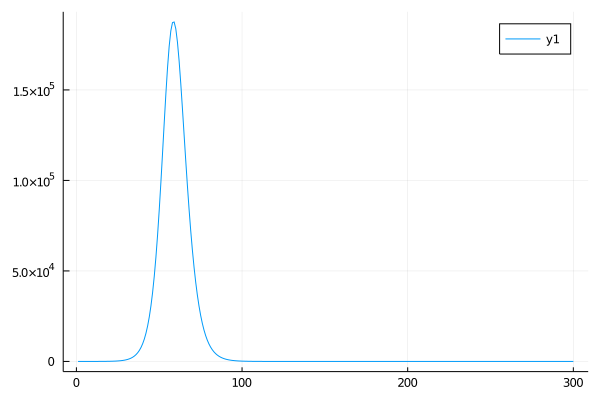

In [117]:
# CONTROL SIMULATION

population1 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params1 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 300)

# Run the model
reset_params!(epi_params1, population1)
set_initial_infected!(epi_params1, population1, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params1, population1; verbose = false)

compartments1 = compartments_as_matrix(epi_params1, population1)
print(size(compartments1))
plot(sum(compartments1, dims=(1,2))[1,1,:,4])

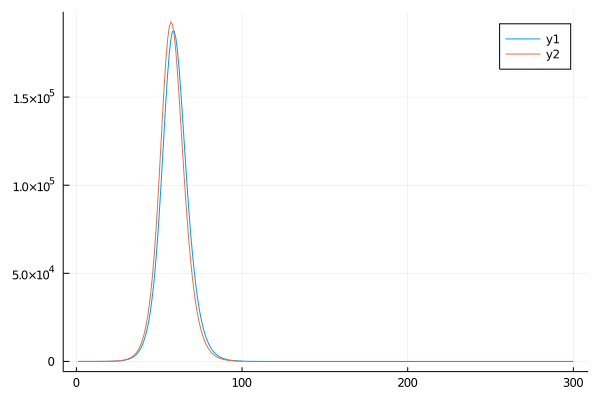

In [191]:
# another simulation that start with a bit different parameters, run until 50 timestamp
population3 = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
epi_params3 = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, 100)

beta, scale_beta = 0.077, 0.51 # default values are: 0.075 and 0.5
epi_params3.βᴵ .= beta
epi_params3.βᴬ .= scale_beta * beta

# Run the model
reset_params!(epi_params3, population3)
set_initial_infected!(epi_params3, population3, E₀, A₀, I₀)
run_epidemic_spreading_mmca!(epi_params3, population3; verbose = false)

compartments3 = compartments_as_matrix(epi_params3, population3)
plot(sum(compartments1, dims=(1,2))[1,1,:,4])
plot!(sum(compartments3, dims=(1,2))[1,1,:,4])

In [182]:
# Functions to correct the compartments at the beginning of each window

function do_nothing(compartments, true_infected, population)
    return compartments
end


function correct_compartments_impute_and_normalize(compartments, true_infected, population)
    compts = copy(compartments) # get compartments of this simulation at the end of the window
    compts[:,:,4] = true_infected
    compts = (compts ./ sum(compts[:,:,:], dims=3)) .* population.nᵢᵍ
    return compts
end


function correct_compartments_distribute_offset(compartments, true_infected, population)
    compts = copy(compartments) # get compartments of this simulation at the end of the window
    
    # calcular el offset generado al imputar infectados
    offset = compts[:,:,4] - true_infected
    
    # imputar infectados
    compts[:,:,4] = true_infected
    
    println(sum(compts))
    
    # repartir el offset entre los compartimentos no infectados
    compts_no_infected = compts[:, :, 1:end .!= 4]
    ratios = compts_no_infected/sum(compts_no_infected)
    compts_no_infected = compts_no_infected + ratios .* offset
    
    println(sum(compts))
    
    # compts = (compts ./ sum(compts[:,:,:], dims=3)) .* population.nᵢᵍ
    return compts
end

correct_compartments_distribute_offset (generic function with 1 method)

10 7.37745946892919 7.37745946892919
20 79.3403153770161 78.33045192794908
30 891.1544384778904 870.5414475402366
40 9787.698330023572 9533.563650826092
50 83611.13601807537 81897.50340195735
60 183770.278831331 184272.73826310612
70 61673.85696648118 62826.897689647245
80 9683.520457211645 9910.032918738765
90 1290.4215993853159 1321.9145976178406
100 171.34979067540237 175.5261321986163
110 23.555827427122843 24.12064311442645
120 3.382655725653588 3.4620282047762876
130 0.506532243102721 0.5181672937941714
140 0.07855086833123945 0.08032318512936734
150 0.012508782242606164 0.012787228497431836
160 0.00202968772503319 0.0020744442657138233
170 0.0003335325601984101 0.00034084157084822675
180 5.526284347096258e-5 5.6469119797623716e-5
190 9.204893376732662e-6 9.405342922755671e-6
200 1.538321397191214e-6 1.5717755698271774e-6


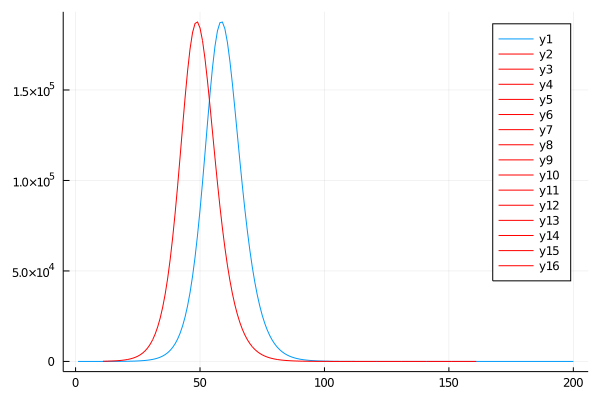

In [203]:
using NamedArrays
simulations_lenght = 100
num_windows = 20
window_size = 10
T = 100

compartments_names = ["S", "E", "A", "I", "PH", "PD", "HR", "HD", "D", "R"]

compartments = zeros(G, M, T, num_compartments, num_windows)

t = 10
initial_compartments = compartments1[:,:,t,:]

for i in 1:num_windows

    println(t, " ", sum(compartments1[:,:,t,4]), " ", sum(initial_compartments[:,:,4]))

    population = Population_Params(G, M, nᵢᵍ, kᵍ, kᵍ_h, kᵍ_w, C, pᵍ, edgelist, Rᵢⱼ, sᵢ, ξ, σ)
    epi_params = Epidemic_Params(βᴵ, βᴬ, ηᵍ, αᵍ, μᵍ, θᵍ, γᵍ, ζᵍ, λᵍ, ωᵍ, ψᵍ, χᵍ, G, M, simulations_lenght+1)

    reset_params!(epi_params, population)
    set_compartments!(epi_params, initial_compartments)
    run_epidemic_spreading_mmca!(epi_params, population; verbose = false)

    compartments[:,:,:,:,i] = compartments_as_matrix(epi_params, population)[:,:,2:end,:]

    t += window_size
    
    compartments_last_day = compartments[:,:,window_size,:,i]
    true_infected = compartments1[:,:,t,4]
    # initial_compartments = correct_compartments_distribute_offset(compartments_last_day, true_infected, population)
    # initial_compartments = correct_compartments_impute_and_normalize(compartments_last_day, true_infected, population)
    initial_compartments = do_nothing(compartments_last_day, true_infected, population)
end



which = 4
points=window_size+1

function plot_simulation!(compartments, w, l)
    x = 1+(window_size*(w-1)):window_size*(w-1)+simulations_lenght
    x = x[1:l]
    y = sum(compartments[:,:,:,which,w], dims=(1,2))[1,1,:]
    y = y[1:l]
    plot!(x, y, color="red", layout=(2,2))
end

plot(sum(compartments1, dims=(1,2))[1,1,1:200,which])
plot_simulation!(compartments, 2, points)
plot_simulation!(compartments, 3, points)
plot_simulation!(compartments, 4, points)
plot_simulation!(compartments, 5, points)
plot_simulation!(compartments, 6, points)
plot_simulation!(compartments, 7, points)
plot_simulation!(compartments, 8, points)
plot_simulation!(compartments, 9, points)
plot_simulation!(compartments, 10, points)
plot_simulation!(compartments, 11, points)
plot_simulation!(compartments, 12, points)
plot_simulation!(compartments, 13, points)
plot_simulation!(compartments, 14, points)
plot_simulation!(compartments, 15, points)
plot_simulation!(compartments, 16, points)
